# Transformers

This notebook is a supplement to the Transformers Chapter of the [Hands-On Generative AI with Transformers and Diffusion Models](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/) book. This notebooks includes:

* The code from the book
* Additional examples
* Exercise solutions.

In [1]:
from google.colab import drive
drive.mount('/content/drive') ## mount drive

import os
path = "/content/drive/MyDrive/code/genaibook/"
os.chdir(path)
print(os.getcwd())

%ls

!pip show tensorflow


Mounted at /content/drive
/content/drive/MyDrive/code/genaibook
01_introduction.ipynb                 07_fine_tuning_diffusion.ipynb
02_transformers.ipynb                 08_creative_applications_of_t2i.ipynb
03_compressing.ipynb                  09_generating_audio.ipynb
04_diffusion.ipynb                    13_rag.ipynb
05_stable_diffusion.ipynb             pyproject.toml
06_fine_tuning_language_models.ipynb  README.md
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, t

In [2]:
from transformers import logging

logging.set_verbosity_error()

## A Language Model in Action

### Tokenizing Text

In [3]:
from transformers import AutoTokenizer

# Use the id of the model you want to use
# GPT-2 "openai-community/gpt2"
# Qwen "Qwen/Qwen2-0.5B"
# SmolLM "HuggingFaceTB/SmolLM-135M"

prompt = "It was a dark and stormy"
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
input_ids = tokenizer(prompt).input_ids
input_ids

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

[1589, 436, 253, 3605, 284, 43471]

In [4]:
for t in input_ids:
    print(t, "\t:", tokenizer.decode(t))

1589 	: It
436 	:  was
253 	:  a
3605 	:  dark
284 	:  and
43471 	:  stormy


### Predicting Probabilities

In [5]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M")

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [6]:
# We tokenize again but specifying the tokenizer that we want it to
# return a PyTorch tensor, which is what the model expects,
# rather than a list of integers
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

outputs = model(input_ids)
outputs.logits.shape  # An output for each input token

torch.Size([1, 6, 49152])

In [7]:
final_logits = model(input_ids).logits[0, -1]  # The last set of logits
final_logits.argmax()  # The position of the maximum

tensor(3163)

In [8]:
tokenizer.decode(final_logits.argmax())

' night'

In [9]:
import torch

top10_logits = torch.topk(final_logits, 10)
for index in top10_logits.indices:
    print(tokenizer.decode(index))

 night
 day
 time
 evening
 winter
 sea
 morning
 month
 summer
 afternoon


In [10]:
top10 = torch.topk(final_logits.softmax(dim=0), 10)
for value, index in zip(top10.values, top10.indices):
    print(f"{tokenizer.decode(index):<10} {value.item():.2%}")

 night     50.05%
 day       17.20%
 time      5.21%
 evening   2.42%
 winter    2.19%
 sea       2.18%
 morning   1.60%
 month     1.34%
 summer    1.33%
 afternoon 1.28%


### Generating Text

**Greedy Decoding**

In [11]:
output_ids = model.generate(input_ids, max_new_tokens=20)
decoded_text = tokenizer.decode(output_ids[0])

print("Input IDs", input_ids[0])
print("Output IDs", output_ids)
print(f"Generated text: {decoded_text}")

Input IDs tensor([ 1589,   436,   253,  3605,   284, 43471])
Output IDs tensor([[ 1589,   436,   253,  3605,   284, 43471,  3163,    28,   284,   260,
          2251,   436, 22753, 39587,    30,   198,   198,    18,  1780,   506,
          4061,    28,  1838,   582,  4817,  3413]])
Generated text: It was a dark and stormy night, and the wind was blowing fiercely.

"What's wrong, little one?" asked


**Beam Search**

In [12]:
beam_output = model.generate(
    input_ids,
    num_beams=5,
    max_new_tokens=30,
)

print(tokenizer.decode(beam_output[0]))

It was a dark and stormy night, and the sky was full of stars.

"What are those twinkling lights in the sky?" asked Timmy.

"Those are


**Beam search with repetition penalty**

In [13]:
beam_output = model.generate(
    input_ids,
    num_beams=5,
    repetition_penalty=2.0,
    max_new_tokens=38,
)

print(tokenizer.decode(beam_output[0]))

It was a dark and stormy night, with the sound of thunder and lightning in the distance. The sky was full of stars, and the sun was setting behind the mountains.

"What are you doing?" asked


**Sampling**

In [14]:
from transformers import set_seed

# Setting the seed ensures we get the same results every time we run this code
set_seed(70)

sampling_output = model.generate(
    input_ids,
    do_sample=True,
    max_new_tokens=34,
    top_k=0,  # We'll come back to this parameter
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy day for the men. Much struggling, expressionless, unmoved by the young women’s words. In contrast, when they slipped to higher ground with the rest


**Sampling with different `temperature`s**

In [15]:
sampling_output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.4,
    max_new_tokens=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy day, with the sky darkening and the sun setting behind the mountains.yard, a small town in the middle of the forest.
The village was the scene of a DG-29 battle


In [16]:
sampling_output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.001,
    max_new_tokens=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy night, and the wind was blowing fiercely.

"What's wrong, little one?" asked the wise old owl, who had seen many things in the forest.

"I can't


In [17]:
sampling_output = model.generate(
    input_ids,
    do_sample=True,
    temperature=3.0,
    max_new_tokens=40,
    top_k=0,
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy rushing bit commit projects fueledranch geom Patterns expects Sons Bow misunderstandingsestern Limitslis nam hurting conflic Levels penguins global em Houston Oak transf panoramicpublicohistitatesatrainitffesvockets Housing ----------------------------------------------------------------BLANK luc monitaxes


**Sampling with `top_k`**

In [18]:
sampling_output = model.generate(
    input_ids,
    do_sample=True,
    max_new_tokens=40,
    top_k=10,
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy night, as the wind picked up, the rain began to fall, and the wind was a roar.
The wind blew the rain from the roof, the rain was pouring down, and the


**Top-p sampling**

In [19]:
sampling_output = model.generate(
    input_ids,
    do_sample=True,
    max_new_tokens=40,
    top_p=0.94,
)

print(tokenizer.decode(sampling_output[0]))

It was a dark and stormy night. A cold rain fell, but the wind blew down the trees, and the leaves turned brown. A light brown tree swayed with the wind.
It felt warm in its limbs. But


### Zero-shot Classification

#### Book code

In [20]:
# Check the token IDs for the words ' positive' and ' negative'
# (note the space before the words)
tokenizer.encode(" positive"), tokenizer.encode(" negative")

([2731], [3524])

In [21]:
def score(review):
    """Predict whether it is positive or negative

    This function predicts whether a review is positive or negative
    using a bit of clever prompting. It looks at the logits for the
    tokens ' positive' and ' negative', and returns the label
    with the highest score.
    """
    prompt = f"""Question: Is the following review positive or
negative about the movie?
Review: {review} Answer:"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids  # <1>
    final_logits = model(input_ids).logits[0, -1]  # <2>
    if final_logits[6785] > final_logits[8225]:  # <3>
        print("Positive")
    else:
        print("Negative")

In [22]:
score("This movie was terrible!")

Positive


In [23]:
score("That movie was great!")

Positive


In [24]:
score("A complex yet wonderful film about the depravity of man")  # A mistake

Positive


#### Suplementary material (not in the book)

This section shows how to use a pre-trained generative model to perform classification via zero-shot classification. We'll use a dataset of labeled reviews and measure the confusion matrix. A confusion matrix serves as a table summarizing a model's performance, depicting counts of true positive, true negative, false positive, and false negative predictions. Rows indicate actual (ground truth) classes, while columns indicate predicted classes. Analyzing this matrix provides insights into the model's strengths and weaknesses in distinguishing between specific classes.

In [25]:

import torch

# 1. 确定最佳可用设备
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    # MPS (Metal Performance Shaders) is for Apple Silicon GPUs
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")


Using device: cuda


Let's use the `HuggingFaceTB/SmolLM-135M` model and its tokenizer.

In [26]:
#from genaibook.core import get_device
from transformers import AutoModelForCausalLM, AutoTokenizer

#device = get_device()
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M").to(device)

Then, we define our `score` function just as in the book, but with some key differences:

* we use 1 (`positive`) and 0 (`negative`),
* we receive a sample so we can use the `datasets` library. You can use this as a dictionary with the review being accessible with `sample["text"]`,
* we add a new column, `pred`, which contains the 0 or 1 from the model.
* we add `truncation=True` to the `tokenizer` call. Truncation is needed as `score` will be called with a batch of samples, and we need to ensure that all samples have the same length. We'll explain in future chapters why this is needed, but for now, just remember that it's necessary when working with batches of samples.

In [27]:
tokenizer.encode(" positive"), tokenizer.encode(" negative")

([2731], [3524])

In [28]:
def score(sample):
    """Given a review, predict whether it is positive or negative using a bit of clever prompting"""
    prompt = f"Question: Is the following review positive or negative about the movie?\nReview: {sample['text']} Answer:"
    input_ids = tokenizer(
        prompt, truncation=True, return_tensors="pt"
    ).input_ids.to(device)
    final_logits = model(input_ids).logits[0, -1]
    if final_logits[6785] > final_logits[8225]:
        sample["pred"] = 1
    else:
        sample["pred"] = 0
    return sample

In [29]:
score({"text": "This movie was terrible!"})

{'text': 'This movie was terrible!', 'pred': 1}

Let's use the [IMDB](https://huggingface.co/datasets/imdb) dataset, which contains 25,000 rows of labeled reviews. We'll use the `datasets` library to load the dataset and load the `train` split.

In [30]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [32]:

from datasets import load_dataset

dataset = load_dataset("imdb")["train"]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

For fast iteration, we'll just use 1000 random samples from the dataset. We'll `shuffle` the dataset and then take the first 1000 samples.

In [33]:
shuffled_dataset = dataset.shuffle(seed=42)
small_dataset = shuffled_dataset.select(range(1000))

Then, we can use the `score` function to predict the sentiment of the reviews and compare the predictions with the actual labels.

In [34]:
updated_dataset = small_dataset.map(score)
updated_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'pred'],
    num_rows: 1000
})

We'll use the `evaluate` library to obtain the confusion matrix. A confusion matrix serves as a table summarizing a model's performance, depicing counts of true positive, true negatives, false positive, and false negative predictions. Rows indicate actual (label) classes, while columns indicate predicted classes. Analyzing this matrix provides insights into the model's strengths and weaknesses in distinguishing between classes. The fine-tune LLM chapter dives into this metric.

In [36]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [37]:
import evaluate

confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=updated_dataset["label"],
    predictions=updated_dataset["pred"],
)
cm

{'confusion_matrix': array([[  0, 512],
        [  0, 488]])}

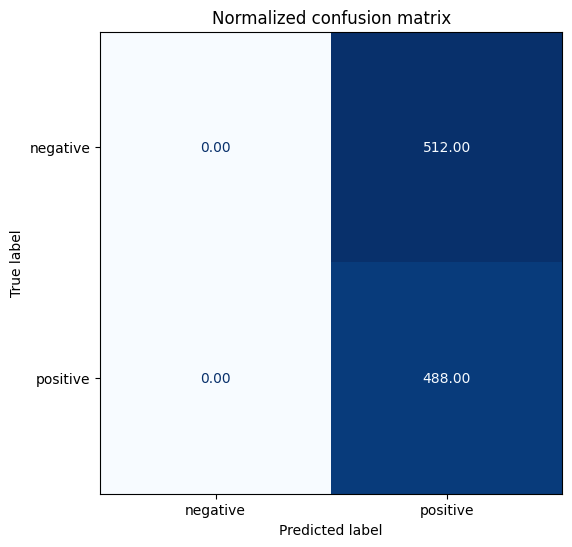

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm["confusion_matrix"],
    display_labels=["negative", "positive"],
)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

What do we get out of these results?

* The model does not perform amazingly well. There are many false negatives.
* The model is very good identifying most negative reviews, but unfortunately marks many positive reviews as negative.

Finally, we can also convert the dataset to a Pandas `DataFrame` and explore the data directly. Here is a starting point

In [39]:
df = updated_dataset.to_pandas()
df.head()

,text,label,pred
0,There is no relation at all between Fortier an...,1,1
1,This movie is a great. The plot is very true t...,1,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,1
3,In the process of trying to establish the audi...,1,1
4,"Yeh, I know -- you're quivering with excitemen...",0,1


**Now it's your turn**. Experiment with tweaking the prompt to improve the model performance. What's the best confusion matrix you can achieve? What if you try another model?

### Few-Shot Generation

In [40]:
# We load the model in CPU again for this section for simplicity
# but feel free to keep in GPU if you prefer.
# Note: you need to move all the data to the device as well.
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M")

In [41]:
prompt = """\
Translate English to Spanish:

English: I do not speak Spanish.
Spanish: No hablo español.

English: See you later!
Spanish: ¡Hasta luego!

English: Where is a good restaurant?
Spanish: ¿Dónde hay un buen restaurante?

English: What rooms do you have available?
Spanish: ¿Qué habitaciones tiene disponibles?

English: I like soccer
Spanish:"""
inputs = tokenizer(prompt, return_tensors="pt").input_ids
output = model.generate(
    inputs,
    max_new_tokens=10,
)

print(tokenizer.decode(output[0]))

Translate English to Spanish:

English: I do not speak Spanish.
Spanish: No hablo español.

English: See you later!
Spanish: ¡Hasta luego!

English: Where is a good restaurant?
Spanish: ¿Dónde hay un buen restaurante?

English: What rooms do you have available?
Spanish: ¿Qué habitaciones tiene disponibles?

English: I like soccer
Spanish: ¿Qué es tu español


## Transformer Models Genealogy

### Encoder-only Models

In [42]:
from transformers import pipeline

fill_masker = pipeline("fill-mask", model="bert-base-uncased")
fill_masker("The [MASK] is made of milk.")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[{'score': 0.19546644389629364,
  'token': 9841,
  'token_str': 'dish',
  'sequence': 'the dish is made of milk.'},
 {'score': 0.12907548248767853,
  'token': 8808,
  'token_str': 'cheese',
  'sequence': 'the cheese is made of milk.'},
 {'score': 0.10590681433677673,
  'token': 6501,
  'token_str': 'milk',
  'sequence': 'the milk is made of milk.'},
 {'score': 0.04112086072564125,
  'token': 4392,
  'token_str': 'drink',
  'sequence': 'the drink is made of milk.'},
 {'score': 0.0371234267950058,
  'token': 7852,
  'token_str': 'bread',
  'sequence': 'the bread is made of milk.'}]

## The Power of Pre-training

### The key Insights of Transformers


In [43]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
)
classifier("This movie is disgustingly good !")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998536109924316}]

### Limitations


In [44]:
unmasker = pipeline("fill-mask", model="bert-base-uncased")
result = unmasker("This man works as a [MASK] during summer.")
print([r["token_str"] for r in result])

result = unmasker("This woman works as a [MASK] during summer.")
print([r["token_str"] for r in result])

['farmer', 'carpenter', 'gardener', 'fisherman', 'miner']
['maid', 'nurse', 'servant', 'waitress', 'cook']


## Beyond Text

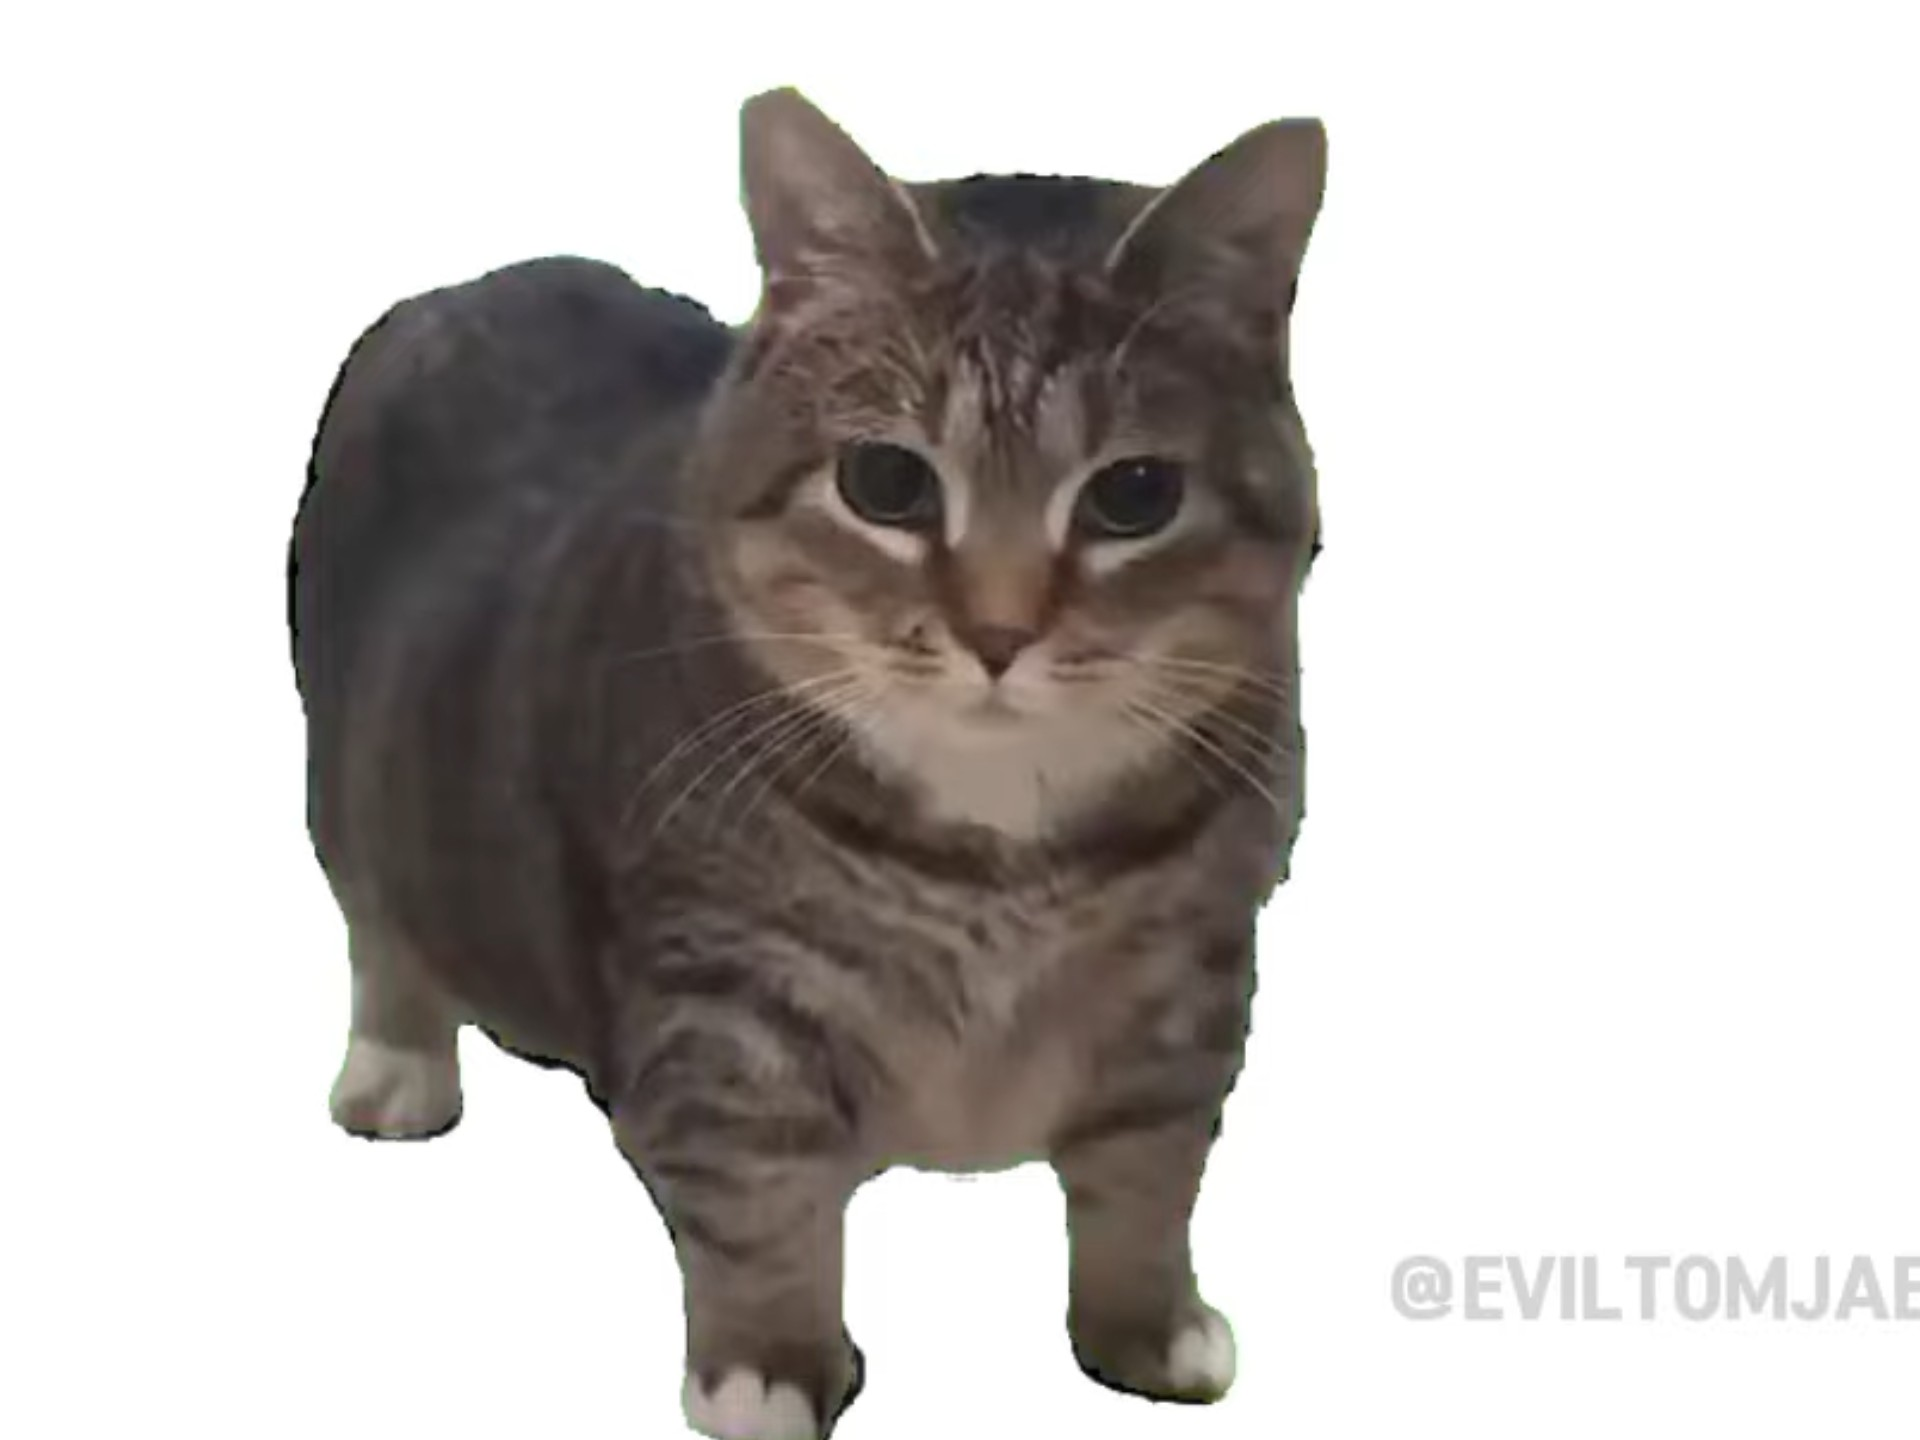

In [45]:
import requests
from PIL import Image

#from genaibook.core import SampleURL

# Download an image and load it with the PIL library
url = "https://i1.hdslb.com/bfs/archive/c4a43bec4ebb5d4dead51b44dd5da1f2f2a4c063.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [46]:
pipe = pipeline(
    "zero-shot-image-classification", model="openai/clip-vit-base-patch32"
)
labels = ["cat", "dog", "zebra"]
pipe(image, candidate_labels=labels)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

[{'score': 0.9848247170448303, 'label': 'cat'},
 {'score': 0.013189990073442459, 'label': 'dog'},
 {'score': 0.0019852430559694767, 'label': 'zebra'}]

## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

### Project Time: Using LMs to Generate Text

This is the solution for the project. Here we'll implement a `generate` function which supports sampling, `top_k`, and greedy search.

In [47]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [48]:
import torch.nn.functional as F


def generate(
    model, tokenizer, input_ids, max_length=50, do_sample=False, top_k=0
):
    """Generate a sequence that starts with `input_ids` without using model.generate().

    Args:
        model (transformers.PreTrainedModel): The model to use for generation.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for generation.
        input_ids (torch.Tensor): The input IDs
        max_length (int, optional): The maximum length of the sequence. Defaults to 50.
        do_sample (bool, optional): Whether to use sampling. Defaults to False.
        top_k (int, optional): The number of tokens to sample from. Defaults to 0.
    """
    current_length = input_ids.size(1)  # Current sequence length

    for _ in range(max_length - current_length):
        # Pass the current sequence through the model
        outputs = model(input_ids)

        # Get logits for the last token in the output
        next_token_logits = outputs.logits[:, -1, :]

        if do_sample:
            if top_k > 0:
                # Apply Top-K filtering
                # Get the indices of the top_k logits
                top_k_logits, _ = torch.topk(next_token_logits, top_k)

                # Get the smallest token from the top_k logits
                min_top_k_value = top_k_logits[:, -1].unsqueeze(-1)

                # Set values smaller than the smallest top_k value to -infinity (probability 0)
                next_token_logits = torch.where(
                    next_token_logits < min_top_k_value,
                    torch.tensor(float("-inf")),
                    next_token_logits,
                )

            # Apply softmax to convert logits to probabilities for sampling
            probs = F.softmax(next_token_logits, dim=-1)
            # Sample the next token from the distribution probability
            next_token_id = torch.multinomial(probs, num_samples=1)
        else:
            # Greedy decoding: choose the token with highest probability
            next_token_id = torch.argmax(
                next_token_logits, dim=-1, keepdim=True
            )

        # Append predicted token to the input sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

        # If the end of sequence token is generated, stop
        if next_token_id == tokenizer.eos_token_id:
            break
    return tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)

In [49]:
input_ids = tokenizer("It was a dark and stormy", return_tensors="pt").input_ids

Let's first try greedy decoding. As it's deterministic, this should give you the same content as in Chapter 2, which was

> It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the

In [50]:
generate(gpt2, tokenizer, input_ids, do_sample=False)

'It was a dark and stormy night. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds were falling. The wind was blowing, and the clouds'

Let's now try sampling with `top_k`

In [51]:
generate(gpt2, tokenizer, input_ids, do_sample=True, top_k=10)

"It was a dark and stormy night. We were out of time, but we got a lot of good news. I was in the hospital, which was a lot of fun. But we were still getting good news from other hospitals. I'm"

### Exercises

**1. What's the role of the attention mechanism in text generation?**

The attention mechanism in text generation allows the model to focus on different parts of the input sequence when producing each token in the output sequence. It helps the model capture long-range dependencies and relationships between words.


**2. In which cases would a character-based tokenizer be preferred?**

A character-based tokenizer might be preferred in cases where the language involves specific characters, symbols, or emojis that carry meaning. For example, in Chinese, each character carries more information than a character in a Latin language.


**3. What happens if you use a tokenizer different from the one used with the model?**

Using a different tokenizer can cause a tokenizer mismatch, leading to inconsistencies in tokenization. This misalignment can result in unexpected or incorrect model outputs.

**4. What's the risk of using `no_repeat_ngram_size` when doing generation? (Hint: Think of city names.)**

If you use a `no_repeat_ngram_size=3`, the "New York City" string will only be generated once. If you're using a generative model to generate a story in NYC, using this penalty will severily hurt it!

**5. What would happen if you combine Beam-search and sampling?**

With beam search, we maintain the `k` best sequences at each timestep. Instead of determinisitcally choosing the top `k` sequences based on the score, we use a probabilistic element and sample the next token from the probability distribution.

This can lead to increased diversity (no repetitive outputs of Beam-search), improved quality (no unpredictable outputs of sampling), and a balance between the two. However, it can require more computational resources due to the increased number of sequences to maintain and sample from.

**6. Imagine you're using a LLM that generates code in a code editor by doing sampling. What would be more convenient? A low temperature or a high temperature?**

In code generation, a low temperature is more convenient as it generates more deterministic and conservative code, adhering to common patterns and reducing the risk of errors. A high temperature would introduce more randomness and could result in unconventional or less reliable code. Therefore, a low temperature is typically preferred.


**7. What’s the importance of fine-tuning, and why is it different from zero-shot generation?**

Fine-tuning is crucial for adapting a pre-trained language model to specific tasks or domains. It allows the model to learn task-specific nuances and improves performance on targeted applications. This differs from zero-shot generation, where the model is used without task-specific training.


**8. Explain the differences and applications of encoder, decoder, and encoderdecoder transformers.**

* **Encoder**: Specialized in processing input sequences and extracting meaningful representations. It's commonly used for tasks like classification, sentiment analysis, and document embeddings. Examples include BERT and RoBERTa.
* **Decoder**: Specialized in generating output sequences based on given input. It's often used for text generation tasks. Examples include GPT-2 and T5.
* **Encoder-Decoder**: Combines both an encoder and a decoder. The encoder processes the input sequence into a set of representations, which the decoder then uses to generate an output sequence. It's ideal for sequence-to-sequence tasks such as machine translation, text summarization, and question answering. Examples include BART and T5.

### Challenges

**9. Summarization. Use a summarization model (you can do `pipeline("summarization)`) to generate summaries of a paragraph. How does it compare with the results of using zero-shot? Can it be beaten by providing few-shot examples?**

Let's first solve this using a summarization model. We'll use a default model, but note that it's a small model from 2020. The results might not be as good as the latest or larger models.

In [52]:
from transformers import pipeline

summarizer = pipeline("summarization")

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [53]:
long_text = """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""

In [54]:
summarizer(long_text)

[{'summary_text': ' The number of engineering graduates in the United States has declined in recent years . China and India graduate six and eight times as many traditional engineers as the U.S. does . Rapidly developing economies such as China continue to encourage and advance the teaching of engineering . There are declining offerings in engineering subjects dealing with infrastructure, infrastructure, the environment, and related issues .'}]

Let's now try with a text generation model.

In [55]:
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [56]:
def summarize_with_zero_shot(long_text):
    zero_shot = generator(
        f"{long_text}.\\n Summary:\\n",
        return_full_text=False,
        max_length=350,
    )

    return zero_shot

In [57]:
summarize_with_zero_shot(long_text)

[{'generated_text': '\n\n    \n        Engineering is the science and discipline of the planning, design, and\n    construction of structures, machines, and apparatus for the purpose of\n    accomplishing work. It is concerned with the creation and the maintenance\n    of tools and apparatus used for the purposes of the engineering arts, or the\n    use of scientific methods in the engineering arts.\n\n    \n    \n        The purpose of engineering is to produce devices that are efficiently\n    produced, useful, and of satisfactory value.\n        Engineering is distinguished from science in that engineering deals\n    with the production of devices that are produced for a particular purpose,\n    such as machines or apparatus and their assembly, rather than the discovery,\n    invention, improvement, and general use of new devices.\n\n    \n    \n\n\\n\n\\n\n\nSummary:\n\nA. A major part of Engineering is concerned with the construction, design,\n  and maintenance of machines, includ

Can you achieve better results by improving the prompt or adding some examples to it?

**10. Sentiment Analysis. In the zero-shot supplementary material, we calculate some metrics using zero-shot classification. Explore using the `distilbert-base-uncased-finetuned-sst-2-english` encoder model that can do sentiment analysis. What results do you get?**

Let's first recall how to use this model. We can either use the `pipeline("text-classification")` approach, or load the model directly with `AutoModel`, which would require handling the tokenization ourselves. We'll want to use `truncation` just as in the zero-shot example above. We begin loading the model and tokenizer. Note that we use `AutoModelForSequenceClassification` to make sure to load the classification layer as well.

In [58]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Let's get the output with a specific example.

In [59]:
input_ids = tokenizer(
    "This movie was terrible!", truncation=True, return_tensors="pt"
).input_ids
classifier_output = model(input_ids)
classifier_output

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.4724, -3.6547]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The output is two logits, which tell us that the first class is more likely than the second. Programmatically, we can do an `argmax` over the `logits` tensor to get the index of the highest value.

In [60]:
predicted_class_id = classifier_output.logits.argmax().item()
predicted_class_id

0

To which class does the 0 correspond to? Using the model configuration `id2label`, we can obtain the corresponding class

In [61]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

And using the model configuration, we can get which label correspond to that id.

In [62]:
model.config.id2label[predicted_class_id]

'NEGATIVE'

Let's wrap this in a function

In [63]:
def score_with_classifier(sample):
    """Given a review, predict whether it is positive or negative"""
    input_ids = tokenizer(
        sample["text"], truncation=True, return_tensors="pt"
    ).input_ids
    classifier_output = model(input_ids)
    sample["pred"] = classifier_output.logits.argmax().item()

    return sample

In [64]:
score_with_classifier({"text": "This movie was terrible!"})

{'text': 'This movie was terrible!', 'pred': 0}

In [65]:
updated_dataset = small_dataset.map(score_with_classifier)
updated_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'pred'],
    num_rows: 1000
})

In [66]:
cm = confusion_matrix.compute(
    references=updated_dataset["label"], predictions=updated_dataset["pred"]
)
cm

{'confusion_matrix': array([[474,  38],
        [ 81, 407]])}

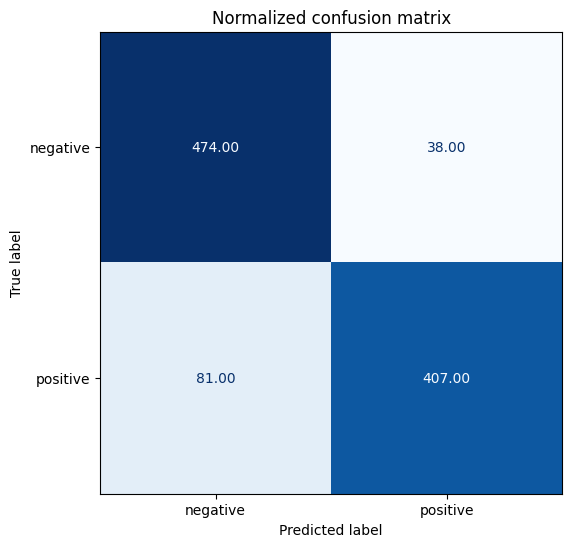

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm["confusion_matrix"],
    display_labels=["negative", "positive"],
)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

plt.title("Normalized confusion matrix")
plt.show()

Impressive! This sentiment analysis classifier performs much better than the zero-shot setup, specially for positive reviews which were being misclassified as negative.

**11. Semantic Search. Let's build a FAQ system! ! Sentence transformers are powerful models that can measure semantic text similarity. While the transformer encoder usually outputs an embedding for each token, sentence transformers output an embedding for the whole input text, allowing us to determine if two texts have similar meanings based on their similarity score. Let’s look at a simple example using the `sentence_transformers` library.**

This is the example provided in the book. We first load the `all-MiniLM-L6-v2` model from the Hub. We then use it to compute the embedding of two sentences using the `encode` method. Each is a tensor (vector) of 384 values. We finally compute the cosine similarity to determine how close both tensors are.

In [68]:
from sentence_transformers import SentenceTransformer, util

sentences = ["I'm happy", "I'm full of happiness"]
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Compute embedding for both lists
embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

util.pytorch_cos_sim(embedding_1, embedding_2)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tensor([[0.6003]], device='cuda:0')

We'll write a dictionary of 5 questions and answers based on Medicare FAQ website.

In [69]:
# Data from https://faq.ssa.gov/en-US/topic/?id=CAT-01092

faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

We can use the `encode` method to compute the embedding of the 5 questions.

In [70]:
corpus_embeddings = model.encode(list(faq.values()), convert_to_tensor=True)
print(corpus_embeddings.shape)

torch.Size([5, 384])


Now, in a production setup, a user would input a question. We can compute its embedding as well.

In [71]:
user_question = "Do I need to pay more after a raise?"
query_embedding = model.encode(user_question, convert_to_tensor=True)
query_embedding.shape

torch.Size([384])

Now, using cosine similarity, we can retrieve the most similar questions from the database - that is, we retrieve the most similar questions based on the highest similarity.

Using `argsort`, we get the top 3 questions and print them.

In [72]:
import numpy as np

similarities = -util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
top_3 = similarities.cpu().argsort()[:3]
for i, top_n in enumerate(top_3):
    print(
        f"Top {i+1} question (p={-similarities[top_n]}): {list(faq.keys())[top_n]}"
    )
    print(f"Answer: {list(faq.values())[top_n]}")

Top 1 question (p=0.3579629361629486): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.27877581119537354): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995
Top 3 question (p=0.15840475261211395): How do I sign up for Medicare?
Answer: If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.


`sentence_transformers` also offers a convenient utility called `semantic_search` for exactly this use case.

In [73]:
similarities = util.semantic_search(
    query_embedding, corpus_embeddings, top_k=3
)[0]
for i, result in enumerate(similarities):
    corpus_id = result["corpus_id"]
    score = result["score"]
    print(f"Top {i+1} question (p={score}): {list(faq.keys())[corpus_id]}")
    print(f"Answer: {list(faq.values())[corpus_id]}")

Top 1 question (p=0.3579629361629486): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.27877581119537354): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995
Top 3 question (p=0.15840475261211395): How do I sign up for Medicare?
Answer: If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.
